# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

Importing external libraries for extended functionality and facilitate code organization by declaring dependencies at the beginning of the notebook, ensuring clear and efficient development.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, r2_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler

1. **Pandas**: is a Python library used for data manipulation and analysis, offering powerful data structures and operations for working with structured data.
2. **Sklearn**: is a Python library for machine learning that provides tools for data mining, data analysis, and machine learning algorithms, built on NumPy, SciPy, and matplotlib.
3. **Numpy**: is a Python library used for efficient numerical computing, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
4. **Seaborn**: is a Python visualization library built on Matplotlib, offering simple syntax for creating attractive, statistical plots, and integrating well with DataFrames.

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
insurance = {
    'local': './datasets/insurance_us.csv',
    'server': '/datasets/insurance_us.csv',
    'online': ''
}

I created a dictionary named `insurance`, mapping keys to file path for an insurance related dataset.

In [3]:
def load_csv(path):
    try:
        return pd.read_csv(path['local'])
    except FileNotFoundError:
        return pd.read_csv(insurance['server'])

I define the `load_csv` function to load a dataset specified by the argument `local`. First, I attempt to read it locally from `local[file_key]`, handling a `FileNotFoundError` by trying to read from `server[file_key]` if necessary, and finally, from `online[file_key]` if all else fails.

In [4]:
df = load_csv(insurance)
df.head(3)

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0


We rename the colums to make the code look more consistent with its style.

In [5]:
df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))

The code renames the DataFrame `df` columns by converting them to lowercase and replacing spaces with underscores for standardization.

In [6]:
df.sample(10)

,gender,age,salary,family_members,insurance_benefits
4049,0,39.0,20900.0,1,0
478,1,53.0,32500.0,1,2
2377,1,32.0,25100.0,1,0
3126,0,51.0,38300.0,1,2
844,0,21.0,39900.0,2,0
511,0,24.0,30500.0,1,0
1479,0,19.0,37500.0,0,0
1103,1,20.0,35200.0,1,0
4874,0,30.0,42500.0,0,0
1953,1,27.0,19700.0,2,0


I sampled 10 random rows from the DataFrame `df`, providing a quick look at its contents.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   salary              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Each column appears to have an appropriate data types.

In [8]:
df.describe()

,gender,age,salary,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


This generates descriptive statistics for the DataFrame `df`, summarizing its numerical columns with metrics like count, mean, and quartiles. None of the values appear to be problematic.

In [9]:
missing_values = df.isnull().sum()
missing_values

gender                0
age                   0
salary                0
family_members        0
insurance_benefits    0
dtype: int64

The dataset is well-documented and contains no missing values.

In [10]:
duplicates = df.duplicated().sum()
duplicates 

153

There are some duplicate values in the dataset, accounting for less than 5% of the total data.

In [11]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.shape

(4847, 5)

After removing the duplicates, we have 4,847 rows remaining.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acoyg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

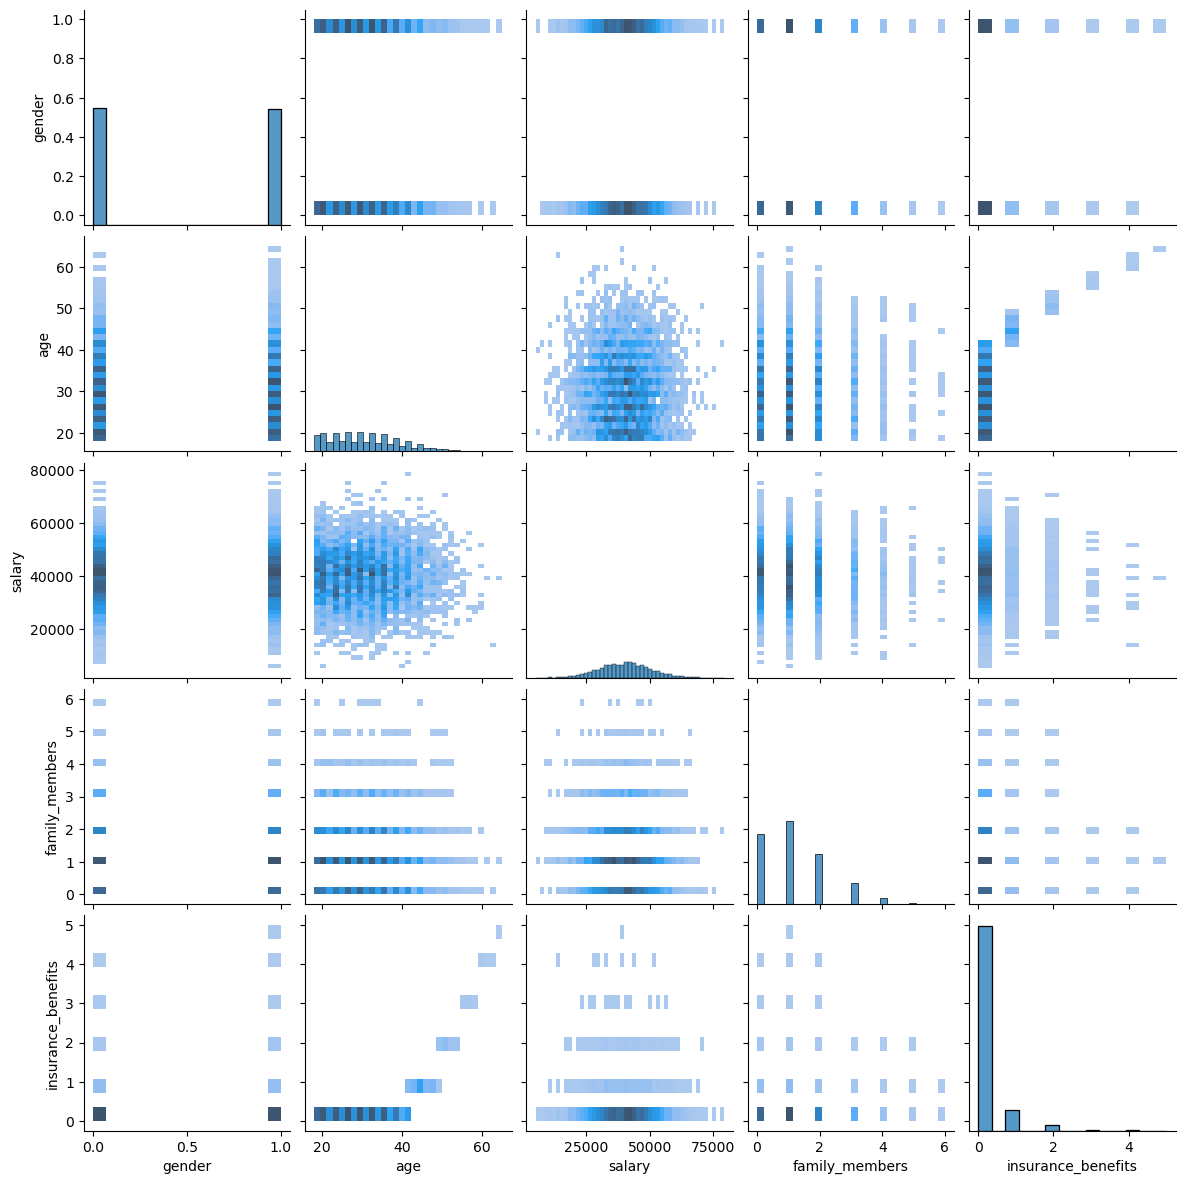

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [13]:
def get_knn(df, metric, n=5, k=3):
    X = df.iloc[:, :-1]
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(X)
    distances, indices = nbrs.kneighbors([df.iloc[n, :-1]], return_distance=True)
    
    knn_df = df.iloc[indices[0]].copy()
    knn_df['distance'] = distances[0]
    
    return knn_df

The `get_knn` function identifies the k-nearest neighbors for the `n`th row in a DataFrame `df`, using the specified `metric`. It returns a DataFrame of the nearest neighbors along with their calculated distances.

In [14]:
def scale_data(df, scaler=MaxAbsScaler()):
    X = df.iloc[:, :-1].astype(float)
    scaled_X = scaler.fit_transform(X)
    
    scaled_df = df.copy()
    scaled_df.iloc[:, :-1] = scaled_X
    
    return scaled_df

The `scale_data` function scales the features (excluding the last column) of a DataFrame `df` using the provided `scaler`, defaulting to `MaxAbsScaler()`. It returns a copy of the DataFrame with the scaled values replacing the original features.

In [15]:
df_scaled = scale_data(df)
df_scaled.head(3)

,gender,age,salary,family_members,insurance_benefits
0,1,0.630769,0.627848,0.166667,0
1,0,0.707692,0.481013,0.166667,1
2,0,0.446154,0.265823,0.000000,0


I have two versions of the dataframe: the processed original and the scaled copy. Next, we'll find similar records for a given one, using both Euclidean and Manhattan distances for every combination.

In [16]:
display(
    get_knn(df,'euclidean'),
    get_knn(df_scaled, 'euclidean'),
    get_knn(df, 'manhattan'),
    get_knn(df_scaled, 'manhattan')
)

c:\Users\acoyg\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\acoyg\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\acoyg\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\acoyg\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,salary,family_members,insurance_benefits,distance
5,1,43.0,41000.0,2,1,0.000000
1965,0,45.0,41000.0,0,1,3.000000
3695,0,46.0,41000.0,2,1,3.162278


,gender,age,salary,family_members,insurance_benefits,distance
5,1,0.661538,0.518987,0.333333,1,0.000000
1136,1,0.646154,0.516456,0.333333,0,0.015592
3955,1,0.661538,0.501266,0.333333,1,0.017722


,gender,age,salary,family_members,insurance_benefits,distance
5,1,43.0,41000.0,2,1,0.0
3860,1,40.0,41000.0,1,0,4.0
3695,0,46.0,41000.0,2,1,4.0


,gender,age,salary,family_members,insurance_benefits,distance
5,1,0.661538,0.518987,0.333333,1,0.000000
3955,1,0.661538,0.501266,0.333333,1,0.017722
1136,1,0.646154,0.516456,0.333333,0,0.017916


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

When observing the data, it appears that the unscaled dataframes tend to show greater distances when using the k-NN algorithm.
**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The Manhattan distances not only show greater values but also appear more consistent compared to other distance measures. This makes sense, as they follow set paths rather than the shortest, straight-line distance.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [17]:
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
df['insurance_benefits_received'].value_counts()

df_scaled = scale_data(df)

The first line creates a new column, `insurance_benefits_received`, by checking if the values in `insurance_benefits` are greater than 0 and converting the result to integers (1 for True, 0 for False). The second line counts the occurrences of each value (0 or 1) in the new column, showing that 4284 individuals did not receive benefits, while 563 did.

In [18]:
def eval_classifier(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, normalize='all')

    print(f'F1 Score: {f1:.2f}\nConfusion Matrix:\n{np.array_str(cm, precision=3, suppress_small=True)}')

The `eval_classifier` function evaluates a classification model by calculating the F1 score and the normalized confusion matrix. It prints the F1 score with two decimal places and the confusion matrix with 3 decimal precision, suppressing small values for readability.

In [19]:
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed)
    return rng.binomial(n=1, p=P, size=size)

The `rnd_model_predict` function generates random predictions based on a specified probability `P`, using a binomial distribution. It takes a `size` parameter to determine the number of predictions to create and a `seed` for reproducibility, defaulting to 42.

In [20]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0.884 0.   ]
 [0.116 0.   ]]

The probability: 0.12
F1 Score: 0.13
Confusion Matrix:
[[0.785 0.099]
 [0.102 0.014]]

The probability: 0.50
F1 Score: 0.19
Confusion Matrix:
[[0.449 0.435]
 [0.059 0.057]]

The probability: 1.00
F1 Score: 0.21
Confusion Matrix:
[[0.    0.884]
 [0.    0.116]]



This code iterates over a list of probabilities (`P`), including 0, the proportion of `insurance_benefits_received`, 0.5, and 1. For each probability, it generates random predictions using the `rnd_model_predict` function, evaluates these predictions against the actual values with the `eval_classifier` function, and prints the F1 score and confusion matrix.

**Observations from the Confusion Matrices:**
- **Probability: 0.00**: The model predicts all zeros, resulting in no positive predictions (True Positives or False Positives), leading to an F1 score of 0.00. The confusion matrix shows a high proportion of true negatives (88.4%) and false negatives (11.6%).
  
- **Probability: 0.12**: The model predicts a small fraction of ones, leading to a low F1 score of 0.13. The confusion matrix indicates that 78.5% of predictions are true negatives, but there are still notable false positives (9.9%) and false negatives (10.2%).

- **Probability: 0.50**: With balanced predictions, the F1 score increases to 0.19. The confusion matrix shows a more even distribution, with 44.9% true negatives and 43.5% false positives, indicating more uncertainty in predictions.

- **Probability: 1.00**: The model predicts all ones, resulting in a higher F1 score of 0.21. The confusion matrix reveals that there are no true negatives, with 88.4% false positives and 11.6% true positives, highlighting the model's tendency to overpredict positive cases. 

Overall, the performance varies with different probabilities, emphasizing the need for careful probability selection to optimize model predictions.

In [21]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

XS = df_scaled.iloc[:, :-1]
y = df_scaled.iloc[:, -1]

XS_train, XS_test, ys_train, ys_test = train_test_split(XS, y, test_size=0.3, random_state=12345)

This code separates the features (`X`) and target variable (`y`) from the DataFrames, then splits the dataset into training (70%) and testing (30%) sets using `train_test_split`, with a random state of 12345 for reproducibility.

In [22]:
def evaluate_knn(k, X_train, X_test, y_train, y_test, scaler=None):
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='all')

    print(f'k: {k}, Scale: {bool(scaler)}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(np.array_str(cm, precision=3, suppress_small=True))
    print()

The `evaluate_knn` function assesses a k-nearest neighbors (KNN) classifier by training it on `X_train` and `y_train`, and then predicting on `X_test`. If a `scaler` is provided, it scales the training and testing data; it then calculates the F1 score and confusion matrix, printing the results along with the value of `k` and whether scaling was applied.

In [23]:
for k in range(1, 11):
    evaluate_knn(k, X_train, X_test, y_train, y_test)
    evaluate_knn(k, X_train, X_test, y_train, y_test, scaler=MaxAbsScaler())


k: 1, Scale: False
F1 Score: 0.69
Confusion Matrix:
[[0.865 0.02 ]
 [0.045 0.071]]

k: 1, Scale: True
F1 Score: 1.00
Confusion Matrix:
[[0.885 0.   ]
 [0.001 0.115]]

k: 2, Scale: False
F1 Score: 0.38
Confusion Matrix:
[[0.88  0.004]
 [0.087 0.028]]

k: 2, Scale: True
F1 Score: 0.99
Confusion Matrix:
[[0.885 0.   ]
 [0.001 0.114]]

k: 3, Scale: False
F1 Score: 0.38
Confusion Matrix:
[[0.871 0.013]
 [0.085 0.03 ]]

k: 3, Scale: True
F1 Score: 1.00
Confusion Matrix:
[[0.885 0.   ]
 [0.001 0.115]]

k: 4, Scale: False
F1 Score: 0.18
Confusion Matrix:
[[0.88  0.005]
 [0.104 0.012]]

k: 4, Scale: True
F1 Score: 0.99
Confusion Matrix:
[[0.885 0.   ]
 [0.002 0.113]]

k: 5, Scale: False
F1 Score: 0.22
Confusion Matrix:
[[0.878 0.006]
 [0.1   0.015]]

k: 5, Scale: True
F1 Score: 0.99
Confusion Matrix:
[[0.885 0.   ]
 [0.002 0.113]]

k: 6, Scale: False
F1 Score: 0.06
Confusion Matrix:
[[0.884 0.001]
 [0.112 0.003]]

k: 6, Scale: True
F1 Score: 0.99
Confusion Matrix:
[[0.885 0.   ]
 [0.002 0.113]]

The output shows a k-nearest neighbors (KNN) classifier for values of `k` ranging from 1 to 10, both with and without feature scaling. Scaling significantly enhances performance, with F1 scores reaching 0.99 or 1.00 when applied, compared to scores between 0.00 and 0.69 without scaling. For `k=1`, the model performs well without scaling (F1 score of 0.69) but achieves perfect classification with scaling. As `k` increases, performance declines without scaling, while the scaled model consistently maintains scores around 0.99. The confusion matrices further illustrate that the scaled model has high true positives and low false positives, indicating better classification overall. These results highlight the critical role of feature scaling in optimizing KNN classifier performance.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [24]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])
        self.weights = np.linalg.pinv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])
        return X2 @ self.weights
# append can change the shape of the array
# hstack stacks arrays horizontally in sequence

The `MyLinearRegression` class implements a simple linear regression model with an `__init__` method that initializes the `weights` attribute to `None`. The `fit` method augments the feature matrix `X` with a column of ones and computes the weights using the pseudo-inverse of this augmented matrix. The `predict` method similarly augments the input `X` and calculates predicted values by multiplying the augmented matrix with the computed `weights`.

In [25]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.2f}\nR2: {r2:.2f}') 

The `eval_regressor` function evaluates a regression model by calculating the root mean squared error (RMSE) and the coefficient of determination (R²) using the true target values (`y_true`) and predicted values (`y_pred`). It computes the RMSE and R² score, then prints both metrics formatted to two decimal places.

In [26]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-1.19074994e-01 -6.61590182e-03  4.82049142e-03  1.48685105e-07
 -1.86326811e-03  5.63494330e-01]
RMSE: 0.14
R2: 0.80


When using Linear Regression the RMSE is 0.14, indicating a low average error in predictions, while the R² value of 0.80 suggests that 80% of the variance in the target variable is explained by the model, reflecting a strong fit.

In [27]:
lr_scaled = MyLinearRegression()

lr_scaled.fit(XS_train, ys_train)
print(lr_scaled.weights)

ys_test_pred = lr_scaled.predict(XS_test)
eval_regressor(ys_test, ys_test_pred)

[-0.11907499 -0.0066159   0.31333194  0.01174612 -0.01117961  2.81747165]
RMSE: 0.14
R2: 0.80


The scaled model's output shows no significant difference in performance compared to the original results. The RMSE and R² remain unchanged, indicating that scaling does not affect model performance in `LinearRegression`.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

Generating a random matrix $P$.

In [28]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [29]:
try:
    P_inv = np.linalg.inv(P)
    print("P is invertible")
except np.linalg.LinAlgError:
    print("P is not invertible")

P is invertible


P is invertible.

Can you guess the customers' ages or income after the transformation?

In [30]:
X_inverse = X @ P
X_inverse

,0,1,2,3,4
0,18432.583713,45999.743638,31968.861008,40815.753676,22012.535927
1,14136.188875,35252.991113,24504.068036,31272.555284,16871.867356
2,7815.051557,19484.137817,13543.963387,17281.709174,9324.759368
3,15483.220157,38663.193138,26865.810492,34313.504922,18501.093525
4,9705.919814,24210.316999,16827.748033,21478.362656,11585.815573
...,...,...,...,...,...
4842,13265.261368,33107.931183,23008.122222,29377.832038,15843.761033
4843,19463.214868,48588.918750,33765.322296,43117.892030,23250.848805
4844,12590.019946,31433.665086,21842.876491,27895.836225,15042.012388
4845,12148.014756,30324.062842,21072.732891,26910.303515,14511.541963


I cannot fully comprehend anything observed in the dataframe.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplication are really helpful here.

In [31]:
X_revert = X_inverse @ P_inv
X_revert
print(f'Both X and X_revert are approximately equal: {np.allclose(X, X_revert)}')

Both X and X_revert are approximately equal: True


Both X and X_revert are approximately equal.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [32]:
display(X, X_inverse, X_revert)

,gender,age,salary,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4842,0,28.0,35700.0,2,0
4843,0,34.0,52400.0,1,0
4844,0,20.0,33900.0,2,0
4845,1,22.0,32700.0,3,0


,0,1,2,3,4
0,18432.583713,45999.743638,31968.861008,40815.753676,22012.535927
1,14136.188875,35252.991113,24504.068036,31272.555284,16871.867356
2,7815.051557,19484.137817,13543.963387,17281.709174,9324.759368
3,15483.220157,38663.193138,26865.810492,34313.504922,18501.093525
4,9705.919814,24210.316999,16827.748033,21478.362656,11585.815573
...,...,...,...,...,...
4842,13265.261368,33107.931183,23008.122222,29377.832038,15843.761033
4843,19463.214868,48588.918750,33765.322296,43117.892030,23250.848805
4844,12590.019946,31433.665086,21842.876491,27895.836225,15042.012388
4845,12148.014756,30324.062842,21072.732891,26910.303515,14511.541963


,0,1,2,3,4
0,1.000000e+00,41.0,49600.0,1.000000e+00,7.275958e-12
1,1.091394e-11,46.0,38000.0,1.000000e+00,1.000000e+00
2,7.275958e-12,29.0,21000.0,3.637979e-12,0.000000e+00
3,3.637979e-12,21.0,41700.0,2.000000e+00,3.637979e-12
4,1.000000e+00,28.0,26100.0,2.273737e-13,-1.818989e-12
...,...,...,...,...,...
4842,-7.275958e-12,28.0,35700.0,2.000000e+00,7.275958e-12
4843,-7.275958e-12,34.0,52400.0,1.000000e+00,7.275958e-12
4844,0.000000e+00,20.0,33900.0,2.000000e+00,3.637979e-12
4845,1.000000e+00,22.0,32700.0,3.000000e+00,-3.637979e-12


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

In [33]:
flaw = X_revert.astype(int)
display(X.head(1), X_revert.head(1), flaw.head(1))

,gender,age,salary,family_members,insurance_benefits
0,1,41.0,49600.0,1,0


,0,1,2,3,4
0,1.0,41.0,49600.0,1.0,7.275958e-12


,0,1,2,3,4
0,0,41,49600,0,0


Matrix inversion always returns floating-point numbers since the inverse of a matrix often contains fractions, even if the original matrix consists of integers. The first dataframe is the original, while the second is the obfuscation version. Most values remain similar or very close, despite the last column having large numbers due to being raised to the power of -12, effectively making them equivalent to zero. In contrast, the last dataframe shows the results of converting values to integers, which can lead to numbers that should equal one becoming zero. This highlights that data can be returned correctly.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The obfuscation method does not change the predicted values of linear regression, as long as the transformation is orthogonal. As seen in our code, the original `X` data and the `X_revert` data are the same, meaning the weights from the obfuscated data will match those from the original data. This ensures that performance metrics like RMSE remain unchanged. Therefore, the obfuscation does not harm the model’s predictive ability.

**Analytical proof**

### Step 1: Linking $w$ and $w_P$

The weight vector for the original linear regression is:

$$
w = (X^T X)^{-1} X^T y
$$

For the obfuscated data, the weights $w_P$ are:

$$
w_P = [(XP)^T (XP)]^{-1} (XP)^T y
$$

Simplifying $w_P$:

1. Substitute $XP$ into the equation:

$$
w_P = [(XP)^T (XP)]^{-1} (XP)^T y
$$

2. Expanding $(XP)^T (XP)$:

$$
(XP)^T (XP) = P^T X^T X P
$$

3. Expanding $(XP)^T y$:

$$
(XP)^T y = P^T X^T y
$$

4. Substituting back:

$$
w_P = [P^T X^T X P]^{-1} P^T X^T y
$$

### Step 2: Simplifying with Matrix Properties

Using the matrix inverse property:

$$
(AB)^{-1} = B^{-1} A^{-1}
$$

We simplify $w_P$:

$$
w_P = P^{-1} (X^T X)^{-1} X^T y = P^{-1} w
$$

### Step 3: Predicted Values

For the original model, the predicted values are:

$$
\hat{y} = Xw
$$

For the obfuscated model:

$$
\hat{y}_P = XPw_P = XP(P^{-1}w) = Xw
$$

Thus:

$$
\hat{y}_P = \hat{y}
$$

### Step 4: Implications for RMSE

Since $\hat{y}_P = \hat{y}$, the RMSE remains unchanged:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_{P,i} - y_i)^2}
$$


## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [34]:
def generate_invertible_matrix(size):
    while True:
        P = np.random.rand(size, size)
        if np.linalg.det(P) != 0:
            return P

The `generate_invertible_matrix` function generates a random square matrix of a specified `size` that is guaranteed to be invertible. It repeatedly creates a random matrix `P` and checks its determinant, returning `P` only if the determinant is non-zero, ensuring the matrix is invertible.

In [35]:
def run_linear_regression(X, y, use_obfuscation=False):
    X_obfuscated = X @ generate_invertible_matrix(X.shape[1]) if use_obfuscation else X

    model = LinearRegression()
    model.fit(X_obfuscated, y)
    predictions = model.predict(X_obfuscated)

    return predictions, np.sqrt(mean_squared_error(y, predictions)), r2_score(y, predictions)

The `run_linear_regression` function performs linear regression on a given feature matrix `X` and target vector `y`, with an optional obfuscation feature. If `use_obfuscation` is set to `True`, it multiplies `X` by a randomly generated invertible matrix to obfuscate the features; otherwise, it uses `X` as is. The function then fits a linear regression model to the (obfuscated) data, makes predictions, and returns the predictions along with the RMSE and R² score for the model's performance.

In [36]:
predictions_original, rmse_original, r2_original = run_linear_regression(X, y)
predictions_obfuscated, rmse_obfuscated, r2_obfuscated = run_linear_regression(X, y, use_obfuscation=True)

print(f'Original - RMSE: {rmse_original:.2f}, R²: {r2_original:.2f}')
print(f'Obfuscated - RMSE: {rmse_obfuscated:.2f}, R²: {r2_obfuscated:.2f}')

Original - RMSE: 0.14, R²: 0.81
Obfuscated - RMSE: 0.14, R²: 0.81


Both the original and obfuscated models yield the same performance metrics, with an RMSE of 0.14 and an R² of 0.81. This indicates that the obfuscation process did not negatively impact the model's accuracy or its ability to explain the variance in the target variable. The consistent performance suggests that the underlying relationships in the data remain intact despite the obfuscation.

# Conclusions

In conclusion, the results emphasize the significant impact of feature scaling on k-NN algorithm performance, with scaled models consistently achieving higher F1 scores and improved classification accuracy. While the scaled model showed no difference regression performance, as indicated by the identical RMSE and R², this may be attributed to factors beyond scaling, such as the obfuscation process. Despite these variations, the obfuscated models maintained similar performance metrics, demonstrating that obfuscation did not adversely affect the model’s ability to predict or explain variance in the target variable. Overall, the findings underscore the importance of both feature scaling and careful data handling in achieving optimal model performance.